In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('dataset.csv') 
t_df = data.copy()

In [3]:
len(t_df)

9042

In [5]:
data.head(15)

,GSTkts,WDIR,WSPDkts,WVHTft,time_stamp
0,9.7,S,7.8,NaN,2020-07-17 14:30:00
1,9.7,S,7.8,NaN,2020-07-17 14:20:00
2,9.7,S,7.8,NaN,2020-07-17 14:10:00
3,9.7,SSE,7.8,NaN,2020-07-17 14:00:00
4,9.7,SSE,7.8,NaN,2020-07-17 13:50:00
5,9.7,SSE,7.8,NaN,2020-07-17 13:40:00
6,7.8,SSE,5.8,NaN,2020-07-17 13:30:00
7,7.8,SSE,5.8,NaN,2020-07-17 13:20:00
8,7.8,SSE,5.8,NaN,2020-07-17 13:10:00
9,7.8,SSE,5.8,NaN,2020-07-17 13:00:00


In [12]:
#data.drop('Unnamed: 0', axis = 1, inplace =True)
#data.to_csv('dataset.csv', index = False)

In [13]:
#get data with wave height
nan_df = t_df.WVHTft > 0
t_df = t_df[nan_df]
len(t_df)

1451

In [14]:
t_df.WDIR.unique()

array(['ENE', 'NE', 'NNE', 'N', 'NNW', 'E', 'NW', 'W', 'WSW', 'SSE',
       'WNW', 'ESE', 'SE', 'S', 'SSW', 'SW'], dtype=object)

In [15]:
#drop blank WDIR from t_df
blank = t_df.WDIR != "-"
t_df = t_df[blank]
len(t_df)

1451

In [16]:
#dummies
t_df = pd.get_dummies(t_df, columns=['WDIR'])

In [23]:
t_df.head(25)

,GSTkts,WSPDkts,WVHTft,time_stamp,WDIR_E,WDIR_ENE,WDIR_ESE,WDIR_N,WDIR_NE,WDIR_NNE,WDIR_NNW,WDIR_NW,WDIR_S,WDIR_SE,WDIR_SSE,WDIR_SSW,WDIR_SW,WDIR_W,WDIR_WNW,WDIR_WSW
7,21.4,17.5,3.0,2020-07-16 12:40:00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,19.4,15.5,3.0,2020-07-16 11:40:00,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
19,15.5,13.6,3.0,2020-07-16 10:40:00,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
25,15.5,11.7,3.0,2020-07-16 09:40:00,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
31,15.5,13.6,3.0,2020-07-16 08:40:00,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
37,15.5,13.6,3.0,2020-07-16 07:40:00,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
43,15.5,13.6,3.3,2020-07-16 06:40:00,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
49,15.5,13.6,3.3,2020-07-16 05:40:00,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
55,13.6,9.7,3.9,2020-07-16 04:40:00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
61,13.6,9.7,4.6,2020-07-16 03:40:00,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [18]:
#run monte carlo simulation and report metrics
scores = []
rmses = []
for i in range(0,1000):
    X_train, X_test, y_train, y_test = train_test_split(t_df.drop(['WVHTft', 'time_stamp'], axis = 1), t_df.WVHTft, test_size=0.15)
    reg = Ridge(alpha = .8).fit(X_train, y_train)
    score = reg.score(X_test, y_test)
    scores.append(score)
    preds = reg.predict(X_test)
    rmses.append(np.sqrt(mean_squared_error(y_test, preds)))
#reg.score(X_test, y_test)
print('min_rmse', np.min(rmses))
print('max_scores', np.max(scores))
print('score', reg.score(X_test, y_test))
print('mean_score', np.mean(scores))
print('mean_rmse', np.mean(rmses))

('min_rmse', 1.1791941103842543)
('max_scores', 0.7040161902748038)
('score', 0.5657357802604702)
('mean_score', 0.5152571286849532)
('mean_rmse', 1.4295168981991935)


In [159]:
#predictions
preds = reg.predict(X_test)
zip(y_test, preds, (y_test - preds))

[(2.6, 3.027173208091972, -0.4271732080919719),
 (3.3, 2.038230157952281, 1.2617698420477188),
 (3.3, 4.282441498652058, -0.982441498652058),
 (3.9, 2.858754907198743, 1.0412450928012569),
 (5.2, 7.342883082159684, -2.142883082159684),
 (3.6, 3.203021177540831, 0.39697882245916905),
 (3.3, 2.6817907630058935, 0.6182092369941063),
 (3.0, 2.5895289890312827, 0.4104710109687173),
 (7.9, 6.3588103173040125, 1.5411896826959879),
 (2.0, 2.4921813404447364, -0.4921813404447364),
 (3.3, 2.8697453466713476, 0.4302546533286522),
 (1.6, 2.742469391543682, -1.142469391543682),
 (9.2, 9.038364052983455, 0.16163594701654382),
 (2.3, 3.624645702771031, -1.324645702771031),
 (8.2, 3.53060082534442, 4.669399174655579),
 (4.3, 4.905839540277503, -0.6058395402775032),
 (6.2, 7.272839548078499, -1.0728395480784991),
 (2.3, 3.034720178910463, -0.7347201789104632),
 (4.3, 5.127497450450555, -0.8274974504505552),
 (1.6, 3.325351368059506, -1.7253513680595058),
 (2.6, 4.28535951789202, -1.6853595178920195),
 

In [160]:
#report rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))
rmse

1.4548419749336423

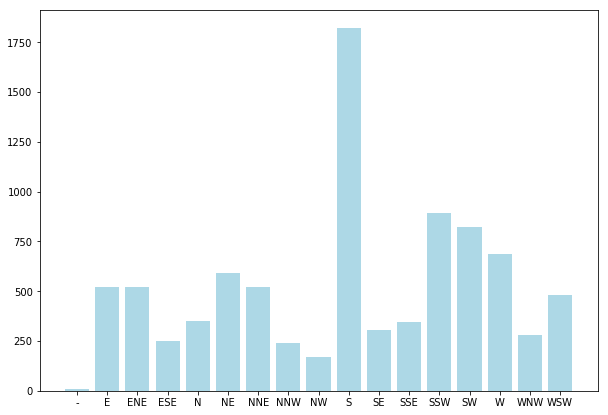

In [146]:
#plot WDIR in df, notice blank
plt.figure(figsize = (10, 7))
wdir_df = pd.DataFrame(data.groupby('WDIR').size(), columns = ['count'])
#wdir_df.drop('-', inplace = True)
bar = wdir_df['count'].values
x = wdir_df.index
plt.bar(x, bar, color = 'lightblue');
#wdir_df

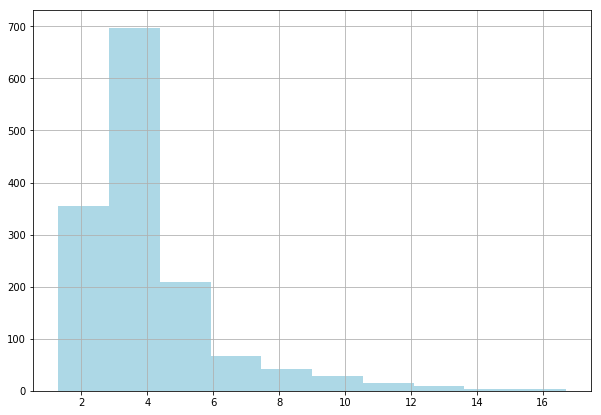

In [147]:
#plot wave height in t_df
plt.figure(figsize = (10, 7))
t_df.WVHTft.hist(color = 'lightblue');

In [148]:
#print coeff for regressor
coefs = list(zip(X_train.columns.tolist(), reg.coef_))
for c in coefs:
    print(c)

('GSTkts', 0.3135038589109576)
('WSPDkts', -0.1500266417196961)
('WDIR_E', 0.19355309023568787)
('WDIR_ENE', 0.42752232920785355)
('WDIR_ESE', 0.43199609094176)
('WDIR_N', -0.6746200067073752)
('WDIR_NE', 0.811928553713418)
('WDIR_NNE', -1.044799300338967)
('WDIR_NNW', -0.5728763189987712)
('WDIR_NW', 0.2301412975941293)
('WDIR_S', -0.4185489794762319)
('WDIR_SE', -0.011886873315737678)
('WDIR_SSE', -0.39045964695795826)
('WDIR_SSW', -0.043738924698824254)
('WDIR_SW', -0.2944215742058236)
('WDIR_W', 0.7553975173664151)
('WDIR_WNW', 0.13787240529072695)
('WDIR_WSW', 0.46294034034877235)
